<a href="https://colab.research.google.com/github/pgdinamica/deeplearning/blob/main/notebooks/RedesConvolucionais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# II Redes Neurais Convolucionais
Material da aula realizada no canal Programação Dinâmica no dia 16 de outubro de 2021. Confira a gravação da aula abaixo.

In [ ]:
from IPython.display import HTML
HTML('''<iframe width="560" height="315" 
        src="https://www.youtube.com/embed/doT7koXt9vw" 
        frameborder="0" allow="accelerometer; autoplay; encrypted-media; 
        gyroscope; picture-in-picture" allowfullscreen></iframe>''')

As redes convolucionais ou redes de convolução têm sido aplicadas com muito sucesso em tarefas relacionadas a imagens. Nesta aula, entenderemos a ideia por trás deste tipo de arquitetura de rede neural e resolveremos um problema de classificação binária de imagens.


# Preparando o Conjunto de Dados

Vamos usar um conjunto de dados de imagens clássico chamado CIFAR10. Este conjunto....



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import matplotlib.pyplot as plt
import os

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
# from torchvision.io import read_image
from torchvision.datasets import CIFAR10

In [4]:
DATA_DIR = '/content/drive/MyDrive/CursoDeepLearning/cifar10'
CATEGORIES = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [5]:
cifar10_train = CIFAR10(DATA_DIR, train=True, download=True)
cifar10_test = CIFAR10(DATA_DIR, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
(len(cifar10_train), len(cifar10_test))

(50000, 10000)

## Vamos visualizar algumas imagens dos dados

In [7]:
def lookat_dataset(dataset, istensor=False):
  figure = plt.figure(figsize=(8, 8))
  rows, cols = 2, 2
  for i in range(1, 5):
      sample_idx = torch.randint(len(dataset), size=(1,)).item()
      img, label = dataset[sample_idx]
      figure.add_subplot(rows, cols, i)
      plt.title(CATEGORIES[label])
      plt.axis("off")
      if istensor:
        plt.imshow(img.squeeze().permute(1, 2, 0))
      else:
        plt.imshow(img)
  plt.show()

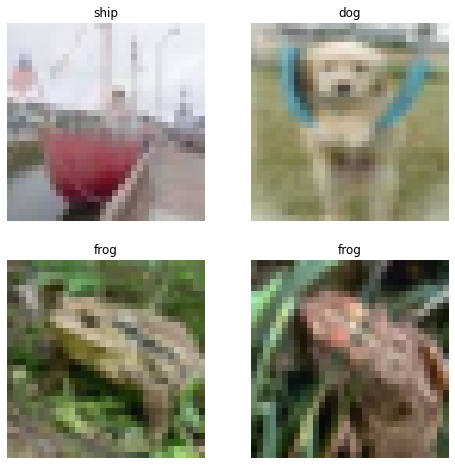

In [8]:
lookat_dataset(cifar10_train)

# Aplicando transformações e dividindo os dados

In [14]:
prep_transform = T.Compose([
                    T.ToTensor(),
                    T.Normalize(
                        (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)
                    )
                  ])

# Applying a transform
tensor_train = CIFAR10(DATA_DIR, train=True, download=False,
                         transform=prep_transform)
tensor_test = CIFAR10(DATA_DIR, train=False, download=False,
                         transform=prep_transform)


In [11]:
# Normalizing data
imgs = torch.stack([img_t for img_t, _ in tensor_train], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [12]:
imgs.view(3, -1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

In [13]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


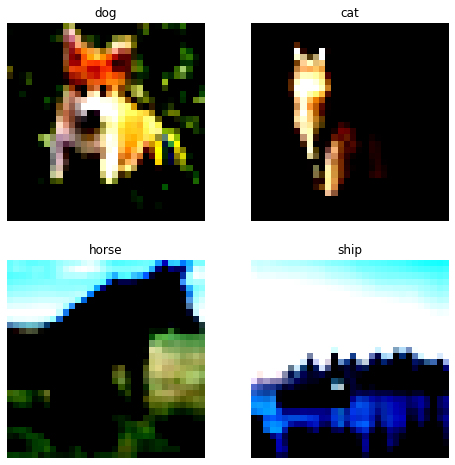

In [15]:
lookat_dataset(tensor_train, True)

## Filtrando o Dataset e Criando DataLoaders

In [16]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2_train = [(img, label_map[label])
          for img, label in tensor_train
          if label in [0, 2]]
cifar2_test = [(img, label_map[label])
              for img, label in tensor_test
              if label in [0, 2]]

In [17]:
batch_size = 64
train_loader = DataLoader(cifar2_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar2_test, batch_size=batch_size, shuffle=False)

# Construindo uma rede MLP 

MLP = MultiLayer Perceptron (multi camadas de perceptrons)

In [18]:
from torch import nn

In [19]:
class MLPClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    
    self.layers = nn.Sequential(
        nn.Linear(3 * 32*32, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 4),
    )

  def forward(self, x):
    v = self.flatten(x)
    return self.layers(v)

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando na {device}")

Rodando na cpu


In [21]:
model = MLPClassifier().to(device)

## Escolhendo os hiperparâmetros de otimização

In [22]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [23]:
def train(model, dataloader, loss_func, optimizer):
  model.train()
  cumloss = 0.0

  for imgs, labels in dataloader:
    imgs, labels = imgs.to(device), labels.to(device)
    
    optimizer.zero_grad()

    pred = model(imgs)

    loss = loss_func(pred, labels)
    loss.backward()
    optimizer.step()

    cumloss += loss.item()

  return cumloss / len(dataloader)

def test(model, dataloader, classes):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  # again no gradients needed
  with torch.no_grad():
      for images, labels in dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1

  # print accuracy for each class
  for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))

## Treinando a rede

In [25]:
epochs = 51
for t in range(epochs):
  train_loss = train(model, train_loader, loss_func, optimizer)
  if t % 10 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")
  

Epoch: 0; Train Loss: 1.3606203080742223
Epoch: 10; Train Loss: 0.5531134377619263
Epoch: 20; Train Loss: 0.47462431431575947
Epoch: 30; Train Loss: 0.4375930690461663
Epoch: 40; Train Loss: 0.4068145360916283
Epoch: 50; Train Loss: 0.3782309843286587


# Avaliando o resultado

In [27]:
test(model, test_loader, ['plane', 'bird'])

Accuracy for class plane is: 85.9 %
Accuracy for class bird  is: 80.0 %


# Construindo uma rede neural de convolução

In [35]:
class ConvolutionalModel(nn.Module):
  def __init__(self):
      super().__init__()
      self.convlayers = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=(3, 3)),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(32, 64, kernel_size=(3, 3)),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(64, 128, kernel_size=(3, 3)),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
      )

      self.linearlayers = nn.Sequential(
          nn.Linear(512, 256),
          nn.ReLU(),
          # nn.Linear(256, 128),
          # nn.ReLU(),
          nn.Linear(256, 4)
      )
      

  def forward(self, x):
      x = self.convlayers(x)
      x = torch.flatten(x, 1)
      return self.linearlayers(x)

In [36]:
convmodel = ConvolutionalModel().to(device)

In [37]:
loss_func2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.SGD(convmodel.parameters(), lr=0.001)

In [38]:
epochs = 51
for t in range(epochs):
  train_loss = train(convmodel, train_loader, loss_func2, optimizer2)
  if t % 10 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")

Epoch: 0; Train Loss: 1.30973158976075
Epoch: 10; Train Loss: 0.5775284892434527
Epoch: 20; Train Loss: 0.5074826873791446
Epoch: 30; Train Loss: 0.46985102022529407
Epoch: 40; Train Loss: 0.433838663587145
Epoch: 50; Train Loss: 0.3994482623733533


In [40]:
test(convmodel, test_loader, ['plane', 'bird'])

Accuracy for class plane is: 80.4 %
Accuracy for class bird  is: 85.3 %


# Avaliando o resultado

In [ ]:
HTML('''<iframe width="560" height="315" 
        src="https://www.youtube.com/embed/ePZswmBSLvc" 
        frameborder="0" allow="accelerometer; autoplay; encrypted-media; 
        gyroscope; picture-in-picture" allowfullscreen></iframe>''')

# E se tivesse mais classes?

# Quero maaaaaaais!!!!


1. [Tutoriais do PyTorch](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)
2. Playlist [Machine Learning com Python](https://youtube.com/playlist?list=PL5TJqBvpXQv5CBxLkdqmou_86syFK7U3Q)
2. [Canal peixe Babel](https://youtu.be/Vfzm1-cfLuc)
3. [Canal Universo Discreto](https://www.youtube.com/watch?v=gbrHEsbTdF0&t=2045s)
4. [Livro Deep Learning](https://www.deeplearningbook.org), Ian GoodFellow
5. [Fundamentos e Tendências em Visão e Processamento de Imagens](https://www.youtube.com/playlist?list=PLo4jXE-LdDTRaFa39TdNN3FgPAKkcuHvj) (Curso do IMPA)
7. Playlist [Diário de Pesquisa](https://youtube.com/playlist?list=PL5TJqBvpXQv4xUJmvSPrP2WI--e5KIgux)

In [ ]:
def valid_extension(name):
  extension = name.split('.')[-1].lower()
  return True if extension in ['jpeg', 'jpg', 'png'] else False

class SportsDataset(Dataset):
  def __init__(self, data_dir, sports, transform=None):
    self.data_dir = data_dir
    self.relative_paths = []
    self.labels = []
    self.transform = transform
    for sport in sports:
      img_names = os.listdir(os.path.join(data_dir, sport))
      filtered_paths = [os.path.join(sport, name) 
                      for name in img_names if valid_extension(name)]
      self.relative_paths.extend(filtered_paths)
      self.labels.extend([sports.index(sport)]*len(filtered_paths))

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    fullpath = os.path.join(self.data_dir, self.relative_paths[idx])
    image = read_image(fullpath)
    label = self.labels[idx]
    if self.transform:
      image = self.transform(image)

    return image, label

In [ ]:
CHOSEN_CATEGORIES = CATEGORIES[:-1]#['basketball', 'formula1']
training_data = SportsDataset(DATA_DIR, CHOSEN_CATEGORIES)